In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [91]:
dir_path='./'
dirr='dataset/'
result_path=dir_path+dirr+'result/'

In [82]:
def load_img(imgg):
    img_dir=imgg
    img1=cv2.imread(dir_path+dirr +img_dir)
    img=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    resized_image=cv2.resize(img1,(300,300),2)
    resized_image.shape
    gray_img=cv2.cvtColor(resized_image,cv2.COLOR_RGB2GRAY)
    plt.title("Gray scale image")
    imgg=plt.imshow(gray_img,cmap='gray')
    print(gray_img.shape)
#     plt.imsave(result_path+str(imgg)+'.jpg',gray_img)
    return gray_img

In [36]:
def calculate_filter_size(T,sigma):
    sHalf=np.round(np.sqrt(-np.log(T)*2*sigma**2))
    N=2*sHalf+1
    return N

In [37]:
def calculate_gradient(sigma,filter_size):
    sHalf=(filter_size-1)/2
    [Y,X]=np.round(np.meshgrid(np.linspace(-sHalf,sHalf,filter_size),np.linspace(-sHalf,sHalf,filter_size)))
    Y.astype(int)
    X.astype(int)
    g_X=np.exp(-(Y**2+X**2)/(2*sigma**2))*(X/sigma)
    g_Y=np.exp(-(Y**2+X**2)/(2*sigma**2))*(Y/sigma)
    G_X=(g_X*255)
    G_Y=(g_Y*255)
    return G_X,G_Y

In [38]:
def convolve2D(image, d_filter, strides=1):
    kernel = np.flipud(np.fliplr(d_filter))

    filter_x = d_filter.shape[0]
    filter_y = d_filter.shape[1]
    img_x = image.shape[0]
    img_y = image.shape[1]

    conv_x = int(((img_x - filter_x ) / strides) + 1)
    conv_y = int(((img_y - filter_y) / strides) + 1)
    conv = np.zeros((conv_x, conv_y))
    
    for y in range(img_y):
        if y > img_y - filter_y:
            break
        if y % strides == 0:
            for x in range(img_x):
                
                if x > img_x - filter_x:
                    break
                try:
                    if x % strides == 0:
                        conv[x, y] = (d_filter * image[x: x + filter_x, y: y + filter_y]).sum()
                except:
                    break
     
    return conv

In [39]:
def calculte_magnitude(fx,fy):
    M=np.zeros((fx.shape[0],fx.shape[1]))
    for i in range(fx.shape[0]):
        for j in range(fx.shape[1]):
            M[i][j]=np.sqrt(fx[i][j]**2+fy[i][j]**2)
    minn=np.min(M)
    maxx=np.max(M)
    M_scaled=(M-minn)/(maxx-minn)
    plt.title('Gradient Magnitude')
    plt.imshow(M,cmap='gray')
    return M_scaled

In [40]:
def compute_grad_direction(fx,fy):
    arctan=np.zeros((fx.shape[0],fx.shape[1]))
    for i in range(fx.shape[0]):
        for j in range(fx.shape[1]):
            angle=math.atan2(fy[i][j],fx[i][j])* 180 / math.pi
            if(angle>0):
                arctan[i][j]=angle
            else:
                arctan[i][j]=angle+360
    plt.title('Gradient Directions')
    plt.imshow(arctan,cmap='gray')
    return arctan

In [41]:
def Grad_Quantization(arctan):
    anglee=np.ones((arctan.shape[0],arctan.shape[1]))
    for i in range(anglee.shape[0]):
        for j in range(anglee.shape[1]):
            q=arctan[i][j]
            if (q>=0 and q<=22.5) or (q>=157.5 and q<=202.5) or (q>=337.5 and q<=360):
                anglee[i][j]=0
            elif (q>22.5 and q<=67.5) or (q>202.5 and q<=247.5):
                anglee[i][j]=1
            elif (q>67.5 and q<=112.5) or (q>247.5 and q<=292.5):
                anglee[i][j]=2
            elif (q>112.5 and q<=157.5) or (q>292.5 and q<=337.5):
                anglee[i][j]=3
    plt.title('Gradient Quantization')
    plt.imshow(anglee,cmap='gray')
    return anglee

In [42]:
def calculte_NMS(anglee,M):
    Mx=M.shape[0]
    My=M.shape[1]
    NMS=np.zeros((Mx,My))
    for i in range(Mx):
        for j in range(My):
            if i == 0 or i == M.shape[0]-1 or j == 0 or j == M.shape[1] - 1:
                NMS[i][j] = 0
                continue
            m=M[i][j]
            if anglee[i][j]==0:
                a=M[i+1][j]
                b=M[i-1][j]
                if m>a and m>b:
                    NMS[i][j]=M[i][j]
                else:
                    NMS[i][j]=0
            elif anglee[i][j]==1:
                a=M[i-1][j-1]
                b=M[i+1][j+1]
                if m>a and m>b:
                    NMS[i][j]=M[i][j]
                else:
                    NMS[i][j]=0
            elif anglee[i][j]==2:
                a=M[i][j+1]
                b=M[i][j-1]
                if m>a and m>b:
                    NMS[i][j]=M[i][j]
                else:
                    NMS[i][j]=0
            else:
                a=M[i-1][j+1]
                b=M[i+1][j-1]
                if m>a and m>b:
                    NMS[i][j]=M[i][j]
                else:
                    NMS[i][j]=0
    plt.title('Non Max Suppression')
    plt.imshow(NMS,cmap='gray')
    return NMS

In [43]:

def H_threshholding(TH,TL,NMSs):
    diff = np.max(NMSs) - np.min(NMSs)
    TL_ratio = np.min(NMSs) + (TL * diff)
    TH_ratio = np.min(NMSs) + (TH * diff)

    out = np.zeros((NMSs.shape[0],NMSs.shape[1]))

    strong_row, strong_col = np.where(NMSs >= TH_ratio)
    zeros_row, zeros_col = np.where(NMSs < TL_ratio)

    weak_row, weak_col = np.where((NMSs <= TH_ratio) & (NMSs >= TL_ratio))

    out[strong_row, strong_col] = 255
    out[zeros_row, zeros_col ] = 0
    out[weak_row, weak_col] = 100

    M, N = out.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (out[i,j] == 100):
                if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                    out[i, j] = 255
                else:
                    out[i, j] = 0
    fig=plt.figure(figsize=(10,10))
    plt.title('Hysterisis Thresholding')
    plt.imshow(out,cmap='gray')
    return out

(300, 300)


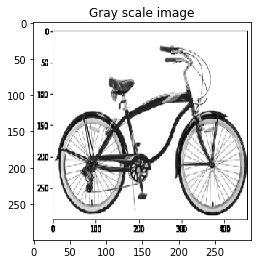

In [279]:
image='cycle.png'
gray_img=load_img(image)
plt.imsave(result_path+'['+str(image)+']'+'.jpg',gray_img,cmap='gray')

In [280]:
sigma=1
T=0.5

In [281]:
N=calculate_filter_size(T,sigma)
print("Size of the derivative filter: ",N)

Size of the derivative filter:  3.0


In [282]:
Gx,Gy=calculate_gradient(sigma,N)

C:\Users\Inspiron\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


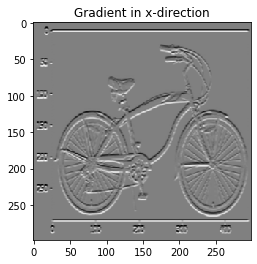

In [283]:
fx=convolve2D(gray_img,Gx,1)
plt.title('Gradient in x-direction')
plt.imshow(fx,cmap='gray')
plt.imsave(result_path+'['+str(image)+']'+'_fx_'+'['+str(sigma)+']'+'.jpg',fx,cmap='gray')

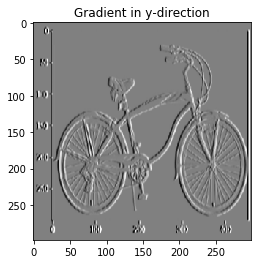

In [284]:
fy=convolve2D(gray_img,Gy,1)
plt.title('Gradient in y-direction')
plt.imshow(fy,cmap='gray')
plt.imsave(result_path+'['+str(image)+']'+'_fy_'+'['+str(sigma)+']'+'.jpg',fy,cmap='gray')


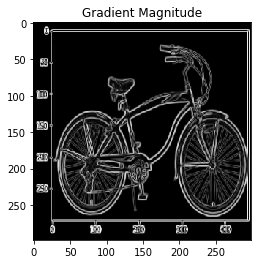

In [285]:
M=calculte_magnitude(fx,fy)
plt.imsave(result_path+'['+str(image)+']'+'_magnitude_'+'['+str(sigma)+']'+'.jpg',M,cmap='gray')

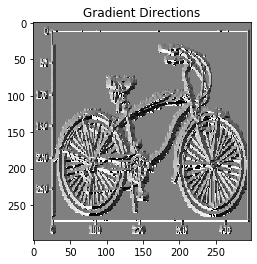

In [286]:
arctan=compute_grad_direction(fx,fy)
plt.imsave(result_path+'['+str(image)+']'+'_grad direction_'+'['+str(sigma)+']'+'.jpg',arctan,cmap='gray')

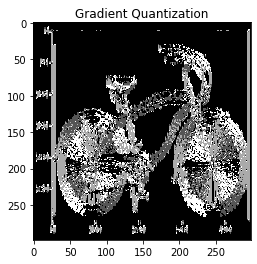

In [287]:
anglee=Grad_Quantization(arctan)
plt.imsave(result_path+'['+str(image)+']'+'_grad Quantization_'+'['+str(sigma)+']'+'.jpg',anglee,cmap='gray')

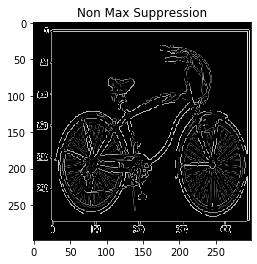

In [288]:
NMS=calculte_NMS(anglee,M)
plt.imsave(result_path+'['+str(image)+']'+'_NMS_'+'['+str(sigma)+']'+'.jpg',NMS,cmap='gray')

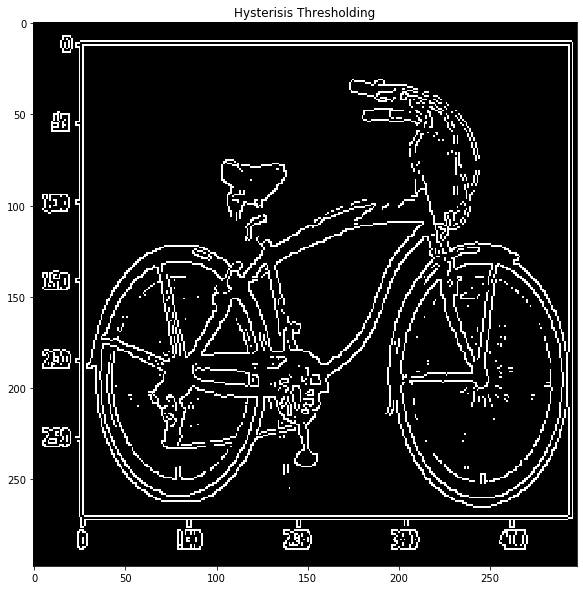

In [289]:
TL=0.10
TH=0.30
out=H_threshholding(TL,TH,NMS)
plt.imsave(result_path+'['+str(image)+']'+'_hysterisis_'+'['+str(sigma)+']'+'_['+str(TL)+']_'+'['+str(TH)+']'+'.jpg',out,cmap='gray')

In [290]:
plt.imsave(result_path+'['+str(image)+']'+'final'+'['+str(sigma)+']'+'_['+str(TL)+']_'+'['+str(TH)+']'+'.jpg',out,cmap='gray')